# Image classification: dogs & cats

In [ ]:
# Handle imports up-front
import os
from typing import Tuple
import shutil

# Silence info. messages from TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.models import Sequential
from keras.preprocessing import image
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model

## 1. Data preparation

### 1.1. Load the data paths

In [ ]:
# Get the path for training images
training_dogs= "../data/processed/train/dog"
training_cats= "../data/processed/train/cat"

In [ ]:
create_val_folder = False

if create_val_folder:
    base_dir = "../data"
    dog_train_dir = training_dogs
    cat_train_dir = training_cats

    validation_dir = os.path.join(base_dir, 'validation')
    os.makedirs(validation_dir)

    cat_valid_dir = os.path.join(validation_dir, "cats")
    dog_valid_dir = os.path.join(validation_dir, "dogs")

    os.makedirs(cat_valid_dir, exist_ok=True)
    os.makedirs(dog_valid_dir, exist_ok=True)

    cat_list = [img for img in os.listdir(cat_train_dir) if 'cat' in img.lower()]
    dog_list = [img for img in os.listdir(dog_train_dir) if 'dog' in img.lower()]

    cat_images = random.sample(cat_list, 1000)
    dog_images = random.sample(dog_list, 1000)

    for img in cat_images:
        shutil.move(os.path.join(cat_train_dir, img), os.path.join(cat_valid_dir, img))

    for img in dog_images:
        shutil.move(os.path.join(dog_train_dir, img), os.path.join(dog_valid_dir, img))

In [3]:
# get the path for validation images
validation_dogs= "../data/validation/dogs"
validation_cats= "../data/validation/cats"

In [9]:
# Function to count images
def count_images(directory, name):
    if not os.path.exists(directory):
        print(f"Directory not found: {directory}")
        return 0
    
    # Filter only image files (common extensions)
    image_extensions = (".jpg", ".jpeg", ".png", ".gif", ".bmp", ".tiff", ".webp")
    image_files = [file for file in os.listdir(directory) if file.lower().endswith(image_extensions)]
    print(f"{name} Folder total images: {len(image_files)}")
    
# Count and print
count_images(training_dogs, 'Dog Training')
count_images(training_cats, 'Cat Training')
count_images(validation_dogs, 'Dog Validation')
count_images(validation_cats, 'Cat Validation')

Dog Training Folder total images: 11500
Cat Training Folder total images: 11500
Dog Validation Folder total images: 1000
Cat Validation Folder total images: 1000


### 1.2. Inspect

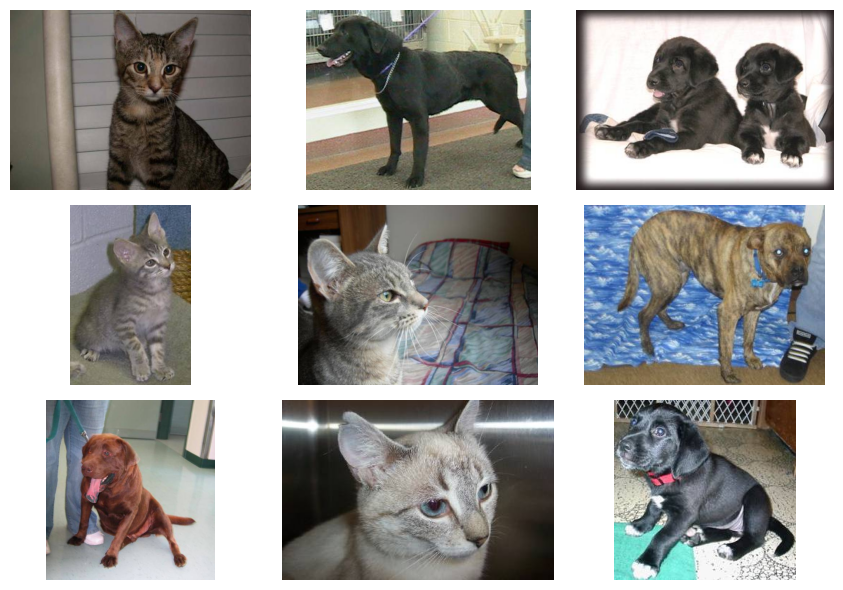

In [18]:
fig, axs = plt.subplots(3, 3, figsize=(9, 6))
axs = axs.flatten()

# Combine cat and dog images to fill 9 slots
training_images = training_cats + training_dogs
random.shuffle(training_images)  # Shuffle the list to mix cats and dogs

# Select only 9 images
training_images = training_images[:9]  

for img_path, ax in zip(training_images, axs):
    img = image.load_img(img_path)
    img = image.img_to_array(img) / 255.0  
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 2. EDA

Let's take a look at a few of our images to get a feel for how image data is structured.

### 2.1. Image data

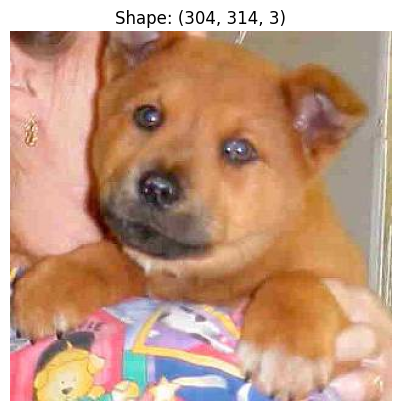

In [22]:
# Load one of the images as an array and look at it's shape - what do you see, what are the dimensions? Are they what you expect?
random_image_path = random.choice(training_cats + training_dogs)
img = image.load_img(random_image_path)
img_array = image.img_to_array(img)

plt.imshow(img_array / 255.0)  # Normalize for display
plt.axis('off')  # Hide axes
plt.title(f"Shape: {img_array.shape}")  # Display shape in title
plt.show()

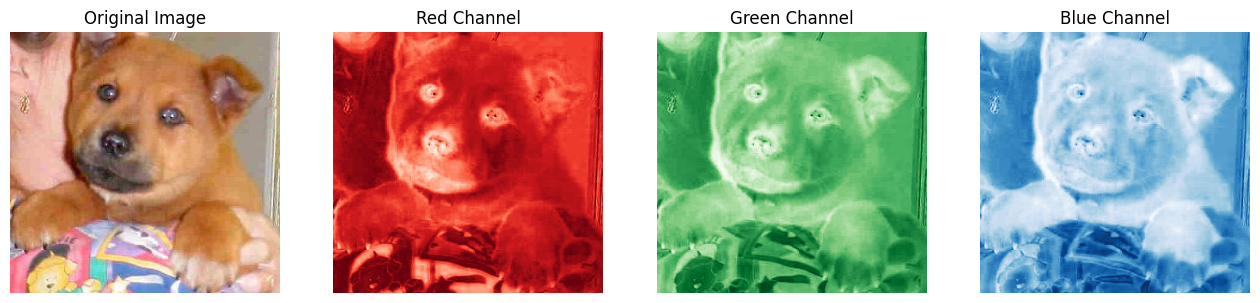

In [23]:
R, G, B = img_array[:, :, 0], img_array[:, :, 1], img_array[:, :, 2]

# Create a figure with 4 subplots (Original + 3 color channels)
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

# Display the original image
axs[0].imshow(img_array / 255.0)
axs[0].set_title("Original Image")
axs[0].axis('off')

# Display Red channel in grayscale
axs[1].imshow(R, cmap='Reds')
axs[1].set_title("Red Channel")
axs[1].axis('off')

# Display Green channel in grayscale
axs[2].imshow(G, cmap='Greens')
axs[2].set_title("Green Channel")
axs[2].axis('off')

# Display Blue channel in grayscale
axs[3].imshow(B, cmap='Blues')
axs[3].set_title("Blue Channel")
axs[3].axis('off')

plt.show()

Areas with high red values will be brighter in the Red Channel.

Areas with high green values will be brighter in the Green Channel.

Areas with high blue values will be brighter in the Blue Channel.

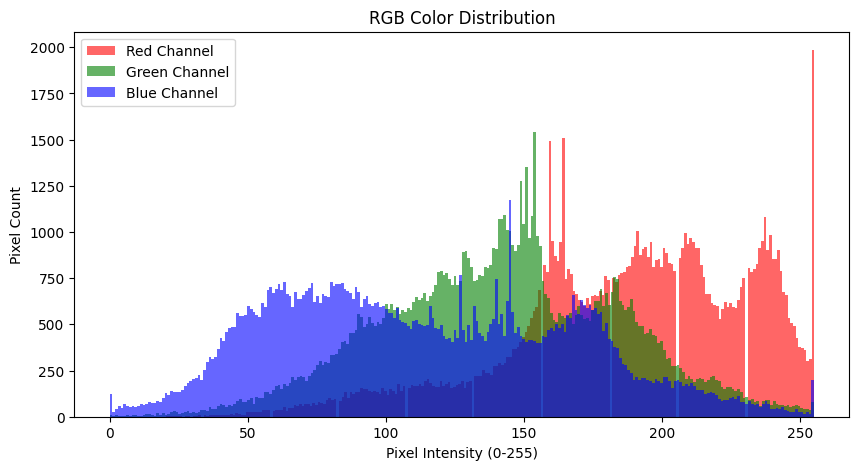

In [24]:
# Plot a histogram of the three 2D arrays which comprise the image. What do you see?
# Plot histograms for each channel
plt.figure(figsize=(10, 5))
plt.hist(R.ravel(), bins=256, color='red', alpha=0.6, label="Red Channel")
plt.hist(G.ravel(), bins=256, color='green', alpha=0.6, label="Green Channel")
plt.hist(B.ravel(), bins=256, color='blue', alpha=0.6, label="Blue Channel")

# Formatting the plot
plt.xlabel("Pixel Intensity (0-255)")
plt.ylabel("Pixel Count")
plt.title("RGB Color Distribution")
plt.legend()
plt.show()

Note the distribution of pixel intensities for each color channel.

Peaks indicate dominant intensity levels.

A balanced histogram suggests a well-distributed color range, while a skewed histogram may indicate a color-dominant image.

### 2.2. Image dimensions and Aspect Ratio

Let's take a look at a random sample of images from the dataset and see what their dimensions are.

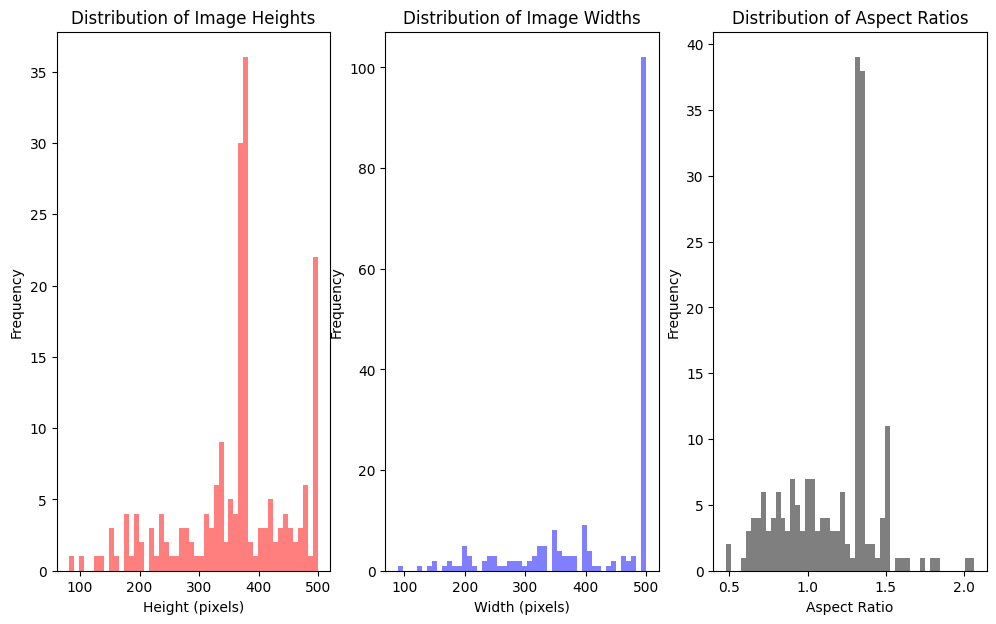

In [37]:
# Loop over a few hundred images and extract their width and heigh, plot both as a histogram. What do you see, does this information matter to us, if so, how?
num_samples = 100
cats = training_cats[:num_samples] 
dogs = training_dogs[:num_samples]

cats_dogs = cats + dogs

height = []
width = []

for img_path in cats_dogs:
    img = image.load_img(img_path)
    img_array = image.img_to_array(img)
    height.append(img_array.shape[0])
    width.append(img_array.shape[1])

aspect_ratio = np.array(width)/np.array(height)

fig, axis = plt.subplots(figsize=(12, 7), ncols=3)

axis[0].hist(height, bins=50, alpha=0.5, color='red')
axis[1].hist(width, bins=50, alpha=0.5, color='blue')
axis[2].hist(aspect_ratio, bins=50, alpha=0.5, color='black')

axis[0].set_xlabel('Height (pixels)')
axis[0].set_ylabel('Frequency')
axis[0].set_title('Distribution of Image Heights')

axis[1].set_xlabel('Width (pixels)')
axis[1].set_ylabel('Frequency')
axis[1].set_title('Distribution of Image Widths')

axis[2].set_xlabel('Aspect Ratio')
axis[2].set_ylabel('Frequency')
axis[2].set_title('Distribution of Aspect Ratios')

plt.show()

If most images have similar aspect ratios, you might be able to resize them proportionally without significant distortion.

Large variations in aspect ratio might require more careful resizing or padding to maintain important features.


## 3. Build the model

### 3.1. Prepare images for streaming

In [4]:
train_data_gen = ImageDataGenerator(rescale=1./255)
valid_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

train_dir = "../data/processed/train"
test_dir = "../data/processed/test"
validation_dir = '../data/validation'



train_generator = train_data_gen.flow_from_directory(train_dir,
                                                    target_size=(200, 200),
                                                    color_mode='grayscale', 
                                                    batch_size=32)

valid_generator = valid_data_gen.flow_from_directory(validation_dir,
                                                        target_size=(200, 200),
                                                        color_mode='grayscale',
                                                        batch_size=32)

test_generator = test_data_gen.flow_from_directory(test_dir,
                                                    target_size=(200, 200),
                                                    color_mode='grayscale', 
                                                    batch_size=32,
                                                    class_mode=None,
                                                    shuffle=False)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


### 3.1. Model definition

In [5]:
# this is the neural net
model = Sequential()
model.add(Input(shape = (200, 200, 1)))
model.add(Conv2D(filters = 64,kernel_size = (3,3),padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))

# These are the dense layer
model.add(Flatten())
model.add(Dense(units = 4096,activation = "relu"))
model.add(Dense(units = 4096,activation = "relu"))
model.add(Dense(units = 2, activation = "softmax"))

### 3.2. Model training

In [6]:
optimizer = AdamW()

model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['acc'])

In [7]:
history = model.fit(train_generator,
                    epochs=1,
                    validation_data=valid_generator) 

/workspaces/Dansah2_ImageClassification_DeepLearning-image-classification/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


: 

### 3.3. Model optimization

In [ ]:
checkpoint = ModelCheckpoint("../models/dog_vs_cat.h5", monitor = "val_accuracy", verbose = 1, save_best_only = True, save_weights_only = False, mode = "auto")
early = EarlyStopping(monitor = "val_accuracy", patience = 3, verbose = 1, mode = "auto")
hist = model.fit(train_generator, steps_per_epoch = 100, validation_data = valid_generator, validation_steps = 10, epochs = 3, callbacks = [checkpoint, early])

## 4. Evaluate the model

In [ ]:
img = image.load_img("../data/raw/test/9.jpg", target_size = (200, 200))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis = 0)
saved_model = load_model("../models/dog_vs_cat.h5")
output = model.predict(img)
if output[0][0] > output[0][1]:
    plt.title("Cat")
else:
    plt.title("Dog")

plt.show()